# **Decision Tree Classifier - A New Evaluation Criterion using KMeans Clustering**

In this IPython Notebook, a decision tree classifier is implemented and tested on the [Avila dataset](https://archive.ics.uci.edu/ml/datasets/Avila) obtained from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). BUT, a ***completely different evaluation criterion*** is used at each non-leaf node of the decision tree when choosing a decision attribute at that node.

There are a few **key** differences from a traditional decision tree.

## Creation of the Node

At each node, 
*   First, check the number of unique classes present in the data that is supplied to that node (the whole dataset if the node is root or a subset of the data after splitting the parent node).
    *   If the number of unique classes is 1, then the node is pure and is a leaf node. The class that will be classified by this leaf node will be that single unique class.
    *   Else if the number of unique classes is more than 1, then the node is impure and can be split. The class that will be classified by this non-leaf node will be the class with the maximum frequency (this information is required in case the node is pruned later and is made a leaf node).
        *    Let the number of unique classes be n where n > 1
        *    Additionally, there is another parameter δ which denotes the ***number of decision attributes*** to be used at any node. This is an important key difference between this decision tree and traditional decision trees. In a traditional decision tree only one attribute could be used as a deciding attribute at any node, but in this decision tree which uses a new evaluation metric, any number of attributes can be used to collectively make a decision. This ***increases the power of the decision tree***.  
        *    The new evaluation metric is nothing but the ***inertia*** of the KMeans Clustering.

```
# This is a pseudo-code to explain the working of this evaluation metric
for all possible combinations of attributes of the data of size δ:
    # This means that if the data has attributes say x, y, z and δ = 3=2,
    # then all possible combinations of attributes of size 2 would be xy, yz, and zx.

    Perform KMeans Clustering on the data using a combination of attributes with n being the number of clusters.

    # From the clustering model we can obtain the inertia and cluster centres.
    Keep track of the combination of attributes and the corresponding KMeans clustering model for which the inertia is the minimum.

# Now we have obtained a clustering model for a combination of attributes for which the inertia is minimum.
Using this model obtain the cluster centres and the corresponding data points which belong to each cluster centre.
Store this information with the node (to be used later when the node is split).
```

## Splitting of the Node

After the node is constructed, as usual if the node is impure it has to be split. BUT, in this decision tree the splitting is done based on the clusters obtained when the node was formed.

We split the impure node into n(number of clusters, also the number of unique classes at the node) nodes. Each child node is sent the data points corresponding a particular cluster centre and then the procedure is repeated for all the children. This constructs the decision tree. 

## Tree traversal for Decision Making

Once the tree is constructed, the traversal is very simple.

To classify a instance of the data say K,

1.   Starting at the root, look at the children of the root. We have already stored the decision attributes combination to be used at the root and the cluster centres corresponding to each child.
2.   Using the values of decision attributes combination in I, check which cluster centre is closest to K.
3.   Then the data point K will be sent to that child whose cluster centre is closest to K. Now go back to Step 1 and repeat.
4.   This process is repeated until a leaf is reached and then K is said to belong to the class corresponding to that leaf.

# Import the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import random
import pickle
import graphviz
import itertools
import threading
from operator                   import itemgetter
from graphviz                   import Digraph
from sklearn.metrics            import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection    import train_test_split

# KMeans Clustering

In [ ]:
class KMeans:
    @staticmethod
    def closest_centre(x, current_cluster_centres, distance_metric):
        distance_to_each_centre = []
        for centre in current_cluster_centres:
            distance = np.linalg.norm(x - centre, distance_metric)
            distance_to_each_centre.append(distance)
        return np.where(distance_to_each_centre == np.amin(distance_to_each_centre))[0][0], np.square(np.amin(distance_to_each_centre))

    def __init__(self, n_clusters=8, max_iter=300, distance_metric=None, algorithm='lloyd', initial_cluster_centres=None):
        if algorithm != "lloyd" and algorithm != "kmeans++":
            print("\n Warning: Permissible methods of initialization are 'lloyd' and 'kmeans++'. algorithm value ignored and set to \'kmeans++\'.")
            algorithm = "kmeans++"
        if initial_cluster_centres is not None and len(initial_cluster_centres) != self.n_clusters:
            print("\n Warning: Number of centres in initial_cluster_centres is not equal to n_clusters. initial_cluster_centres ignored and set to None.")
            initial_cluster_centres = None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.algorithm = algorithm
        self.initial_cluster_centres_ = initial_cluster_centres
        self.cluster_centres_ = None
        self.labels_ = None
        self.inertia_ = None

    def lloyd_cluster_centre_initialization(self, X):
        return X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

    def kmeans_plus_plus_cluster_centre_initialization(self, X):
        first_random_choice_for_centre = np.random.choice(X.shape[0], 1, replace=False)
        current_cluster_centres = X[first_random_choice_for_centre]
        for i in range(2, self.n_clusters + 1):
            sum_of_square_of_min_distances = 0
            probability_of_x_being_a_centre = []
            for x in X:
                _, distance_squared = self.closest_centre(x, current_cluster_centres, self.distance_metric)
                probability_of_x_being_a_centre.append(distance_squared)
                sum_of_square_of_min_distances += distance_squared
            sum_of_square_of_min_distances += 0.000001
            probability_of_x_being_a_centre = np.true_divide(np.array(probability_of_x_being_a_centre, dtype=float), sum_of_square_of_min_distances)
            current_cluster_centres = np.append(current_cluster_centres, [X[np.where(probability_of_x_being_a_centre == np.amax(probability_of_x_being_a_centre))[0][0]]], axis=0)
        return current_cluster_centres

    def fit(self, X):
        current_cluster_centres = None
        inertia = None
        labels = None
        if self.initial_cluster_centres_ is None:
            if self.algorithm == 'kmeans++':
                current_cluster_centres = np.array(self.kmeans_plus_plus_cluster_centre_initialization(X), dtype=float)
            elif self.algorithm == 'lloyd':
                current_cluster_centres = np.array(self.lloyd_cluster_centre_initialization(X), dtype=float)
        else:
            current_cluster_centres = np.array(self.initial_cluster_centres_, dtype=float)
        iterator = 1
        while iterator <= self.max_iter:
            recomputed_cluster_centres = {}
            number_of_data_points_per_cluster = {}
            inertia = 0.0
            labels = []
            for x in X:
                label_of_x, distance_squared = self.closest_centre(x, current_cluster_centres, self.distance_metric)
                labels.append(label_of_x)
                inertia += distance_squared
                if label_of_x in recomputed_cluster_centres:
                    recomputed_cluster_centres[label_of_x] = np.add(recomputed_cluster_centres[label_of_x], x)
                    number_of_data_points_per_cluster[label_of_x] += 1
                else:
                    recomputed_cluster_centres[label_of_x] = x
                    number_of_data_points_per_cluster[label_of_x] = 1
            for label in recomputed_cluster_centres:
                recomputed_cluster_centres[label] = np.true_divide(recomputed_cluster_centres[label], number_of_data_points_per_cluster[label])
            flag = True
            for i in range(0, self.n_clusters):
                if i in recomputed_cluster_centres and not np.array_equal(current_cluster_centres[i], recomputed_cluster_centres[i]):
                    flag = False
                if i in recomputed_cluster_centres:
                    current_cluster_centres[i] = np.array(copy.deepcopy(recomputed_cluster_centres[i]), dtype=float)
            if flag:
                break
            iterator += 1
        self.cluster_centres_ = np.array(copy.deepcopy(current_cluster_centres), dtype=float)
        self.inertia_ = inertia
        self.labels_ = np.array(labels)
        
    def predict(self, X):
        labels = []
        for x in X:
            label_of_x, _ = self.closest_centre(x, self.cluster_centres_, self.distance_metric)
            labels.append(label_of_x)
        return labels

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

# Node of the Decision Tree

In [ ]:
class Node:
    @staticmethod
    def frequency(x):
        return np.unique(np.array(x), return_counts=True)

    def __init__(self, tree, x, y, attributes_left, column_names, parent_depth, max_depth=500, number_of_decision_attributes=1, distance_metric=None, clustering_algorithm='lloyd', clustering_max_iter=300):
        tree.node_id_lock.acquire()
        self.id = tree.node_id
        tree.node_id += 1
        tree.node_id_lock.release()
        self.attributes_left = attributes_left
        self.depth = parent_depth + 1
        self.distance_metric = distance_metric
        self.is_leaf = False
        self.decision_attributes = None
        self.decision_attributes_names = None
        self.cluster_centers_cum_child = None
        self.indices_list = None
        self.inertia = None
        rows, columns = x.shape
        y_vals, frequencies = self.frequency(y)
        self.vote = y_vals[np.argmax(frequencies)]
        if self.depth < max_depth and len(y_vals) > 1 and len(self.attributes_left) > 0 and rows > 0:
            _n_clusters = len(y_vals)
            _minimum_within_cluster_sum_of_square = None
            _decision_attributes = None
            _clustering_model = None
            _cluster_center_cum_child = []
            for _decision_attributes_combination in list(itertools.combinations(attributes_left, number_of_decision_attributes)):
                _decision_attributes_combination = list(_decision_attributes_combination)
                clustering_model = KMeans(n_clusters=_n_clusters, max_iter=clustering_max_iter, distance_metric=self.distance_metric, algorithm=clustering_algorithm)
                clustering_model.fit(x[:, _decision_attributes_combination])
                if _minimum_within_cluster_sum_of_square is None or clustering_model.inertia_ < _minimum_within_cluster_sum_of_square:
                    _minimum_within_cluster_sum_of_square = clustering_model.inertia_
                    _decision_attributes = _decision_attributes_combination
                    _clustering_model = copy.deepcopy(clustering_model)
            self.inertia = _minimum_within_cluster_sum_of_square
            self.decision_attributes = _decision_attributes
            self.decision_attributes_names = itemgetter(*(self.decision_attributes))(column_names)
            for _cluster_center in _clustering_model.cluster_centres_:
                _cluster_center_cum_child.append([_cluster_center, ])
            self.cluster_centers_cum_child = copy.deepcopy(_cluster_center_cum_child)
            self.indices_list = []
            _count_of_children = 0
            for i in range(0, _n_clusters):
                _index_list_for_ith_cluster = x[_clustering_model.labels_ == i, 0].astype(dtype=np.int64)
                if len(_index_list_for_ith_cluster) == 0:
                    self.cluster_centers_cum_child[i] = [None, None]
                    self.indices_list.append(None)
                else:
                    self.indices_list.append(_index_list_for_ith_cluster)
                    _count_of_children += 1
            if _count_of_children == 1:
                self.is_leaf = True
        else:
            self.is_leaf = True
        # print("************************")
        # print("Node ID: ", self.id)
        # print("Vote: ", self.vote)
        # print("Is Leaf: ", self.is_leaf)
        # print("Decision Attributes: ", self.decision_attributes_names)
        # print("Cluster Center: ", self.cluster_centers_cum_child)
        # print("Inertia: ", self.inertia)
        # print("************************")

    def test(self, x, usable_depth):
        if self.depth > usable_depth or self.is_leaf:
            return self.vote
        else:
            new_x = x[self.decision_attributes]
            minimum_distance = None
            next_child = None
            for center, child in self.cluster_centers_cum_child:
                if center is not None and child is not None:
                    distance = np.linalg.norm(new_x - center, ord=self.distance_metric)
                    if minimum_distance is None or distance < minimum_distance:
                        minimum_distance = distance
                        next_child = child
            return next_child.test(x, usable_depth)

    def get_info(self):
        if not self.is_leaf:
            return "node #{}, attribute={}, vote={}".format(self.id, self.decision_attributes_names, self.vote)
        return "node #{}, vote={}".format(self.id, self.vote)

# Decision Tree

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, reuse_attribute=False, max_depth=100, number_of_decision_attributes=1, distance_metric=None, clustering_algorithm='lloyd', clustering_max_iter=300):
        self.node_id = 1
        self.node_id_lock = threading.Lock()
        self.reuse_attribute = reuse_attribute
        self.max_depth = max_depth
        self.number_of_decision_attributes = number_of_decision_attributes
        self.distance_metric = distance_metric
        self.clustering_algorithm = clustering_algorithm
        self.clustering_max_iter = clustering_max_iter
        self.root = None
        self.node_dict = {}
        self.node_at_depth_count = {}
        self.X_train = None
        self.y_train = None

    def fit(self, x, y, column_names):
        self.X_train = x
        self.y_train = y
        rows, columns = self.X_train.shape
        attributes_list = list(range(1, columns))
        self.root = Node(self, x=self.X_train, y=self.y_train, attributes_left=attributes_list, column_names=column_names, parent_depth=0, max_depth=self.max_depth, number_of_decision_attributes=self.number_of_decision_attributes, distance_metric=self.distance_metric, clustering_algorithm=self.clustering_algorithm, clustering_max_iter=self.clustering_max_iter)
        self.node_dict[self.root.id] = self.root
        if '1' not in self.node_at_depth_count.keys():
            self.node_at_depth_count['1'] = 1
        else:
            self.node_at_depth_count['1'] += 1
        if not self.reuse_attribute:
            for attribute in self.root.decision_attributes:
                attributes_list.remove(attribute)
        self.build(self.root, attributes_list)
        self.node_id_lock = None

    def build(self, root, attributes_left):
        if not root.is_leaf:
            for i in range(0, len(root.cluster_centers_cum_child)):
                if root.indices_list[i] is not None:
                    subset_mask = np.isin(self.X_train[:, 0].astype(np.int64), root.indices_list[i])
                    child = Node(self, x=self.X_train[subset_mask, :], y=self.y_train[subset_mask], attributes_left=attributes_left, column_names=column_names, parent_depth=root.depth, max_depth=self.max_depth, number_of_decision_attributes=self.number_of_decision_attributes, distance_metric=self.distance_metric, clustering_algorithm=self.clustering_algorithm, clustering_max_iter=self.clustering_max_iter)
                    root.cluster_centers_cum_child[i].append(child)
                    self.node_dict[child.id] = child
            if str(root.depth + 1) not in self.node_at_depth_count.keys():
                self.node_at_depth_count[str(root.depth + 1)] = len(root.cluster_centers_cum_child)
            else:
                self.node_at_depth_count[str(root.depth + 1)] += len(root.cluster_centers_cum_child)
            t = []
            for i in range(0, len(root.cluster_centers_cum_child)):
                attributes_list_copy = copy.deepcopy(attributes_left)
                child = root.cluster_centers_cum_child[i][1]
                if child is not None:
                    if not child.is_leaf:
                        if not self.reuse_attribute:
                            for attribute in child.decision_attributes:
                                attributes_list_copy.remove(attribute)
                        t_ = threading.Thread(target=self.build, args=(child, attributes_list_copy,))

                        t.append(t_)
                        t_.start()
            for t_ in t:
                t_.join()

    def predict_thread(self, x, y, use_depth, i):
        y[i] = self.root.test(x, use_depth)

    def predict(self, x, use_depth=100):
        rows, _ = x.shape
        y_predict = [0]*rows
        t = []
        for i in range(0, rows):
            t_ = threading.Thread(target=self.predict_thread, args=(x[i, :], y_predict, use_depth, i,))
            t.append(t_)
            t_.start()
        for t_ in t:
            t_.join()
        return y_predict

    @staticmethod
    def prune_thread(model, id, accuracy_dict, X_valid, y_valid, minimum_increase, accuracy_before_pruning):
        model_temp = copy.deepcopy(model)
        model_temp.node_dict[id].is_leaf = True
        accuracy_after_pruning = accuracy_score(y_valid, model_temp.predict(X_valid))
        if accuracy_after_pruning > accuracy_before_pruning + minimum_increase:
            accuracy_dict[id] = accuracy_after_pruning
        model_temp.node_dict[id].is_leaf = False

    @staticmethod
    def prune_thread_for_stopping_rounds(model, id, accuracy_dict, X_valid, y_valid):
        model_temp = copy.deepcopy(model)
        model_temp.node_dict[id].is_leaf = True
        accuracy_dict[id] = accuracy_score(y_valid, model_temp.predict(X_valid))
        model_temp.node_dict[id].is_leaf = False

    def prune(self, evaluation_set, minimum_increase=0.001, maximum_rounds=10, sample_size=10, stopping_rounds=0):
        (X_valid, y_valid) = evaluation_set
        accuracy_before_pruning = accuracy_score(y_valid, self.predict(X_valid))
        for i in range(0, maximum_rounds+1):
            accuracy_dict = {}
            sample_size = min(len(self.node_dict.items()), sample_size)
            random_sample = dict(random.sample(self.node_dict.items(), sample_size))
            t = []
            print("************************")
            print("Pruning Step: ", i)
            print("Number of nodes in the Tree: ", len(self.node_dict))
            print("************************")
            for node_i in random_sample.values():
                if not node_i.is_leaf:
                    t_ = threading.Thread(target=self.prune_thread, args=(self, node_i.id, accuracy_dict, X_valid, y_valid, minimum_increase, accuracy_before_pruning,))
                    t.append(t_)
                    t_.start()
            for t_ in t:
                t_.join()
            if len(accuracy_dict) == 0:
                if sample_size >= len(self.node_dict):
                    break
                else:
                    continue
            max_accuracy_node_id = max(accuracy_dict, key=accuracy_dict.get)
            pruned_node = self.node_dict[max_accuracy_node_id]
            # print("************************")
            # print("Pruned Node with ID: ", pruned_node.id)
            # print("Accuracy after pruning on Validation Set: ", accuracy_dict[max_accuracy_node_id]*100)
            # print("Increase in accuracy: ", (accuracy_dict[max_accuracy_node_id]-accuracy_before_pruning)*100)
            # print("************************")
            self.remove_children(pruned_node.id)
            pruned_node.is_leaf = True
            accuracy_before_pruning = accuracy_dict[max_accuracy_node_id]
        if stopping_rounds > 0 and len(self.node_dict) > 0:
            accuracy_before_last_round = accuracy_score(y_valid, self.predict(X_valid))
            accuracy_after_last_round = accuracy_before_last_round
            for i in range(0, stopping_rounds):
                accuracy_dict = {}
                sample_size = min(len(self.node_dict.items()), sample_size)
                random_sample = dict(random.sample(self.node_dict.items(), sample_size))
                t = []
                for node_i in random_sample.values():
                    if not node_i.is_leaf:
                        t_ = threading.Thread(target=self.prune_thread_for_stopping_rounds, args=(self, node_i.id, accuracy_dict, X_valid, y_valid,))
                        t.append(t_)
                        t_.start()
                for t_ in t:
                    t_.join()
                if len(accuracy_dict) == 0:
                    continue
                max_accuracy_node_id = max(accuracy_dict, key=accuracy_dict.get)
                # print("************************")
                # print("Pruning On Stopping Rounds")
                # print("Pruned Node with ID: ", max_accuracy_node_id)
                # print("Accuracy after pruning on Validation Set: ", accuracy_dict[max_accuracy_node_id]*100)
                # print("Change in accuracy: ", (accuracy_dict[max_accuracy_node_id]-accuracy_before_last_round)*100)
                # print("************************")
                if i < stopping_rounds-1:
                    accuracy_before_last_round = accuracy_dict[max_accuracy_node_id]
                accuracy_after_last_round = accuracy_dict[max_accuracy_node_id]
                pruned_node = self.node_dict[max_accuracy_node_id]
                self.remove_children(pruned_node.id)
                pruned_node.is_leaf = True
            if accuracy_after_last_round > accuracy_before_last_round + minimum_increase:
                self.prune(evaluation_set, stopping_rounds=0)

    @staticmethod
    def prune_node_vary_thread(model, id, accuracy_dict, X_valid, y_valid):
        model_temp = copy.deepcopy(model)
        model_temp.node_dict[id].is_leaf = True
        accuracy_dict[id] = accuracy_score(y_valid, model_temp.predict(X_valid))
        model_temp.node_dict[id].is_leaf = False

    def prune_node_vary(self, evaluation_set_train, evaluation_set_test, evaluation_set_val):
        train_accuracies = []
        test_accuracies = []
        val_accuracies = []
        prunes = []
        (X_train, y_train) = evaluation_set_train
        (X_test, y_test) = evaluation_set_test
        (X_valid, y_valid) = evaluation_set_val
        pruned = 0
        pruned_flag = False
        accuracy_before_pruning = accuracy_score(y_valid, self.predict(X_valid))
        while len(self.node_dict) > 1:
            train_acc = accuracy_score(y_train, self.predict(X_train))
            test_acc = accuracy_score(y_test, self.predict(X_test))
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            val_accuracies.append(accuracy_before_pruning)
            prunes.append(len(self.node_dict))
            accuracy_dict = {}
            t = []
            print("************************")
            print(f"Pruning Step : {pruned}")
            print(f"Number of nodes in the tree: {len(self.node_dict.values())}")
            print("************************")
            for node_i in self.node_dict.values():
                if not node_i.is_leaf:
                    t_ = threading.Thread(target=self.prune_node_vary_thread, args=(self, node_i.id, accuracy_dict, X_valid, y_valid))
                    t.append(t_)
                    t_.start()
            for t_ in t:
                t_.join()
            if len(accuracy_dict) == 0:
                break
            max_accuracy_node_id = max(accuracy_dict, key=accuracy_dict.get)
            accuracy_after_pruning = accuracy_dict[max_accuracy_node_id]
            pruned_node = self.node_dict[max_accuracy_node_id]
            self.remove_children(pruned_node.id)
            pruned_node.is_leaf = True
            if not pruned_flag and accuracy_after_pruning < accuracy_before_pruning:
                pickle.dump(self, open("fully_pruned_decision_tree.dat", "wb"))
                self.print_decision_tree(f"fully_pruned_")
                pruned_flag = True
            pickle.dump(self, open(f"pruning_step_{pruned}_decision_tree.dat", "wb"))
            self.print_decision_tree(f"pruning_step_{pruned}_")
            np.save(open("train_accuracies.npy", "wb"), train_accuracies)
            np.save(open("test_accuracies.npy", "wb"), test_accuracies)
            np.save(open("val_accuracies.npy", "wb"), val_accuracies)
            np.save(open("prunes.npy", "wb"), prunes)
            pruned = pruned + 1
            accuracy_before_pruning = accuracy_dict[max_accuracy_node_id]
        return train_accuracies, test_accuracies, val_accuracies, prunes

    def remove_children(self, node_id):
        if node_id not in self.node_dict or self.node_dict[node_id].is_leaf:          
            return
        elif self.node_dict[node_id].cluster_centers_cum_child is not None and len(self.node_dict[node_id].cluster_centers_cum_child) != 0:
            for _, child in self.node_dict[node_id].cluster_centers_cum_child:
                if child is not None:
                    self.remove_children(child.id)
                    if child.id in self.node_dict:
                        self.node_dict.pop(child.id)

    def print_decision_tree(self, filepath=""):
        f = Digraph('Decision Tree', filename=f'{filepath}decision_tree.gv')
        f.attr(rankdir='LR', size='1000,500')
        f.attr('node', shape='rectangle')
        if self.root.is_leaf:
            f.node("node #{} , vote={}".format(self.root.id, self.root.vote))
        else:
            q = [self.root]
            while len(q) > 0:
                node = q.pop(0)
                if not node.is_leaf:
                    for i in range(0, len(node.cluster_centers_cum_child)):
                        if node.cluster_centers_cum_child[i][0] is not None and node.cluster_centers_cum_child[i][1] is not None:
                            f.edge(node.get_info(), node.cluster_centers_cum_child[i][1].get_info(), label='center=' + str(node.cluster_centers_cum_child[i][0]))
                            q.append(node.cluster_centers_cum_child[i][1])
        f.render(f'{filepath}decision_tree.gv', view=True)
        with open(f"{filepath}decision_tree.gv") as f:
            dot_graph = f.read()
        graphviz.Source(dot_graph)
        os.remove(f"{filepath}decision_tree.gv")

# Analysis PART - 1

In [ ]:
filepath = '../input/avila-dataset-and-saved-variables/'

In [ ]:
df = pd.read_csv(filepath+'avila_combined.txt', delimiter=",", header=None)

column_names = ['index', 'intercolumnar distance', 'upper margin', 'lower margin', 'exploitation', 'row number', 'modular ratio',
              'interlinear spacing', 'weight', 'peak number', 'modular ratio/ interlinear spacing']

X = df.iloc[:, 0:-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
index = np.arange(X.shape[0])
X = np.c_[index, X]

In [ ]:
def on_average_analysis_thread(X, y, i, column_names, output, N):
    X_sub, X_test, y_sub, y_test = train_test_split(X, y, test_size=0.2, random_state=i*N + 1*N)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sub, y_sub, test_size=0.1, random_state=i*N + 1*N)
    model = DecisionTreeClassifier(reuse_attribute=False, max_depth=100, number_of_decision_attributes=1, distance_metric=None, clustering_algorithm='kmeans++', clustering_max_iter=300)
    model.fit(X_train, y_train, column_names)
    y_predict = model.predict(X_test)
    ac = accuracy_score(y_test, y_predict)
    output[i] = (ac, model, X_test, y_test, X_valid, y_valid, X_train, y_train)

N = 5
t = []
output = [0]*N
for i in range(0, N):
    t_ = threading.Thread(target=on_average_analysis_thread, args=(X, y, i, column_names, output, N, ))        
    t.append(t_)
    t_.start()
for t_ in t:
    t_.join()

final_model = None
max_test_accuracy = 0.0
final_X_test = None
final_y_test = None
final_X_valid = None
final_y_valid = None
final_X_train = None
final_y_train = None
accuracy_sum = 0.0
analysisFile = open('analysis.txt', 'w')
for i in range(0, N):
    ac, model, X_test, y_test, X_valid, y_valid, X_train, y_train = output[i]
    print("***********************", file=analysisFile)
    print(f"Random split #{i + 1} ", file=analysisFile)
    print(f"Accuracy = {ac * 100}%", file=analysisFile)
    print("***********************", file=analysisFile)
    accuracy_sum += ac
    if ac > max_test_accuracy:
        max_test_accuracy = ac
        final_model = model
        final_X_test = X_test
        final_y_test = y_test
        final_X_valid = X_valid
        final_y_valid = y_valid
        final_X_train = X_train
        final_y_train = y_train
accuracy_sum /= N    

print("Number of nodes in the tree: ", len(final_model.node_dict), file=analysisFile)

final_model.print_decision_tree(f"")

y_predict = final_model.predict(final_X_test)
ac = accuracy_score(final_y_test, y_predict)
print(f"Maximum Accuracy = {ac * 100}%, average accuracy = {accuracy_sum * 100}%", file=analysisFile)

classes = np.unique(final_y_test)
matrix = confusion_matrix(final_y_test, y_predict, labels=classes)
print('Confusion matrix : \n', matrix, file=analysisFile)

matrix = classification_report(final_y_test, y_predict, labels=classes)
print('Classification report : \n', matrix, file=analysisFile)

pickle.dump(final_model, open("final_model.dat", "wb"))
np.save(open(filepath+"final_X_train.npy", "wb"), final_X_train)
np.save(open(filepath+"final_y_train.npy", "wb"), final_y_train)
np.save(open(filepath+"final_X_test.npy", "wb"), final_X_test)
np.save(open(filepath+"final_y_test.npy", "wb"), final_y_test)
np.save(open(filepath+"final_X_valid.npy", "wb"), final_X_valid)
np.save(open(filepath+"final_y_valid.npy", "wb"), final_y_valid)
analysisFile.close()

***********************
Random split #1 
Accuracy = 86.15237182558697%
***********************
***********************
Random split #2 
Accuracy = 89.57834211787255%
***********************
***********************
Random split #3 
Accuracy = 87.2065165309056%
***********************
***********************
Random split #4 
Accuracy = 88.83564925730714%
***********************
***********************
Random split #5 
Accuracy = 90.08145663632008%
***********************

    Number of nodes in the tree:  3443

    Maximum Accuracy = 90.08145663632008%, average accuracy = 88.37086727359846%

    Confusion matrix : 
     
     [[1594    0    1    0    7  110   26   15    0    1    0    0]
     [   0    2    0    0    0    0    0    0    0    0    0    0]
     [   1    0   33    0    0    0    0    1    0    0    0    0]
     [   0    0    0  141    4    0    0    0    0    0    0    0]
     [  11    0    0    9  417    4    1    1    0    0    8    0]
     [ 117    0    0    0    2  630    4    4    0    0    0    0]
     [  12    0    0    0    6   18  145    2    0    0    0    0]
     [  17    0    0    0    3    8    3  182    0    0    0    0]
     [   0    0    0    0    0    0    0    0  323    0    0    0]
     [   0    0    0    0    0    0    0    0    0   15    0    0]
     [   6    0    0    0    4    0    0    0    0    0  174    6]
     [   0    0    0    0    0    0    0    0    0    0    2  104]]
 
    Classification report : 

              precision    recall  f1-score   support
               
           A       0.91      0.91      0.91      1754
           B       1.00      1.00      1.00         2
           C       0.97      0.94      0.96        35
           D       0.94      0.97      0.96       145
           E       0.94      0.92      0.93       451
           F       0.82      0.83      0.83       757
           G       0.81      0.79      0.80       183
           H       0.89      0.85      0.87       213
           I       1.00      1.00      1.00       323
           W       0.94      1.00      0.97        15
           X       0.95      0.92      0.93       190
           Y       0.95      0.98      0.96       106
           
        accuracy                           0.90      4174
       macro avg       0.93      0.93      0.93      4174
    weighted avg       0.90      0.90      0.90      4174

# Analysis for Depth of Tree

In [ ]:
train_accuracies = []
test_accuracies = []
val_accuracies = []
depths = []
nodes = []

max_depth = 10
for depth in range(1, max_depth+1):
    y_predict = final_model.predict(final_X_test, use_depth=depth)
    ac = accuracy_score(final_y_test, y_predict)
    test_accuracies.append(ac)
    y_predict = final_model.predict(final_X_train, use_depth=depth)
    ac = accuracy_score(final_y_train, y_predict)
    train_accuracies.append(ac)
    y_predict = final_model.predict(final_X_valid, use_depth=depth)
    ac = accuracy_score(final_y_valid, y_predict)
    val_accuracies.append(ac)
    depths.append(depth)
    if not len(nodes):
        nodes.append(final_model.node_at_depth_count[str(depth)])
    else:
        if str(depth) in final_model.node_at_depth_count.keys():
            nodes.append(nodes[-1] + final_model.node_at_depth_count[str(depth)])
        else:
            nodes.append(nodes[-1])

plt.plot(depths, train_accuracies, label="training accuracy")
plt.plot(depths, test_accuracies, label="test accuracy")
plt.plot(depths, val_accuracies, label="validation accuracy")
plt.legend()
plt.xlabel('Depth of the Decision Tree')
plt.ylabel('Accuracy')
plt.title("Evaluation Criterion - KMeans Clustering")
plt.savefig(f'depth_analysis.png', dpi=300, bbox_inches='tight')
plt.clf()

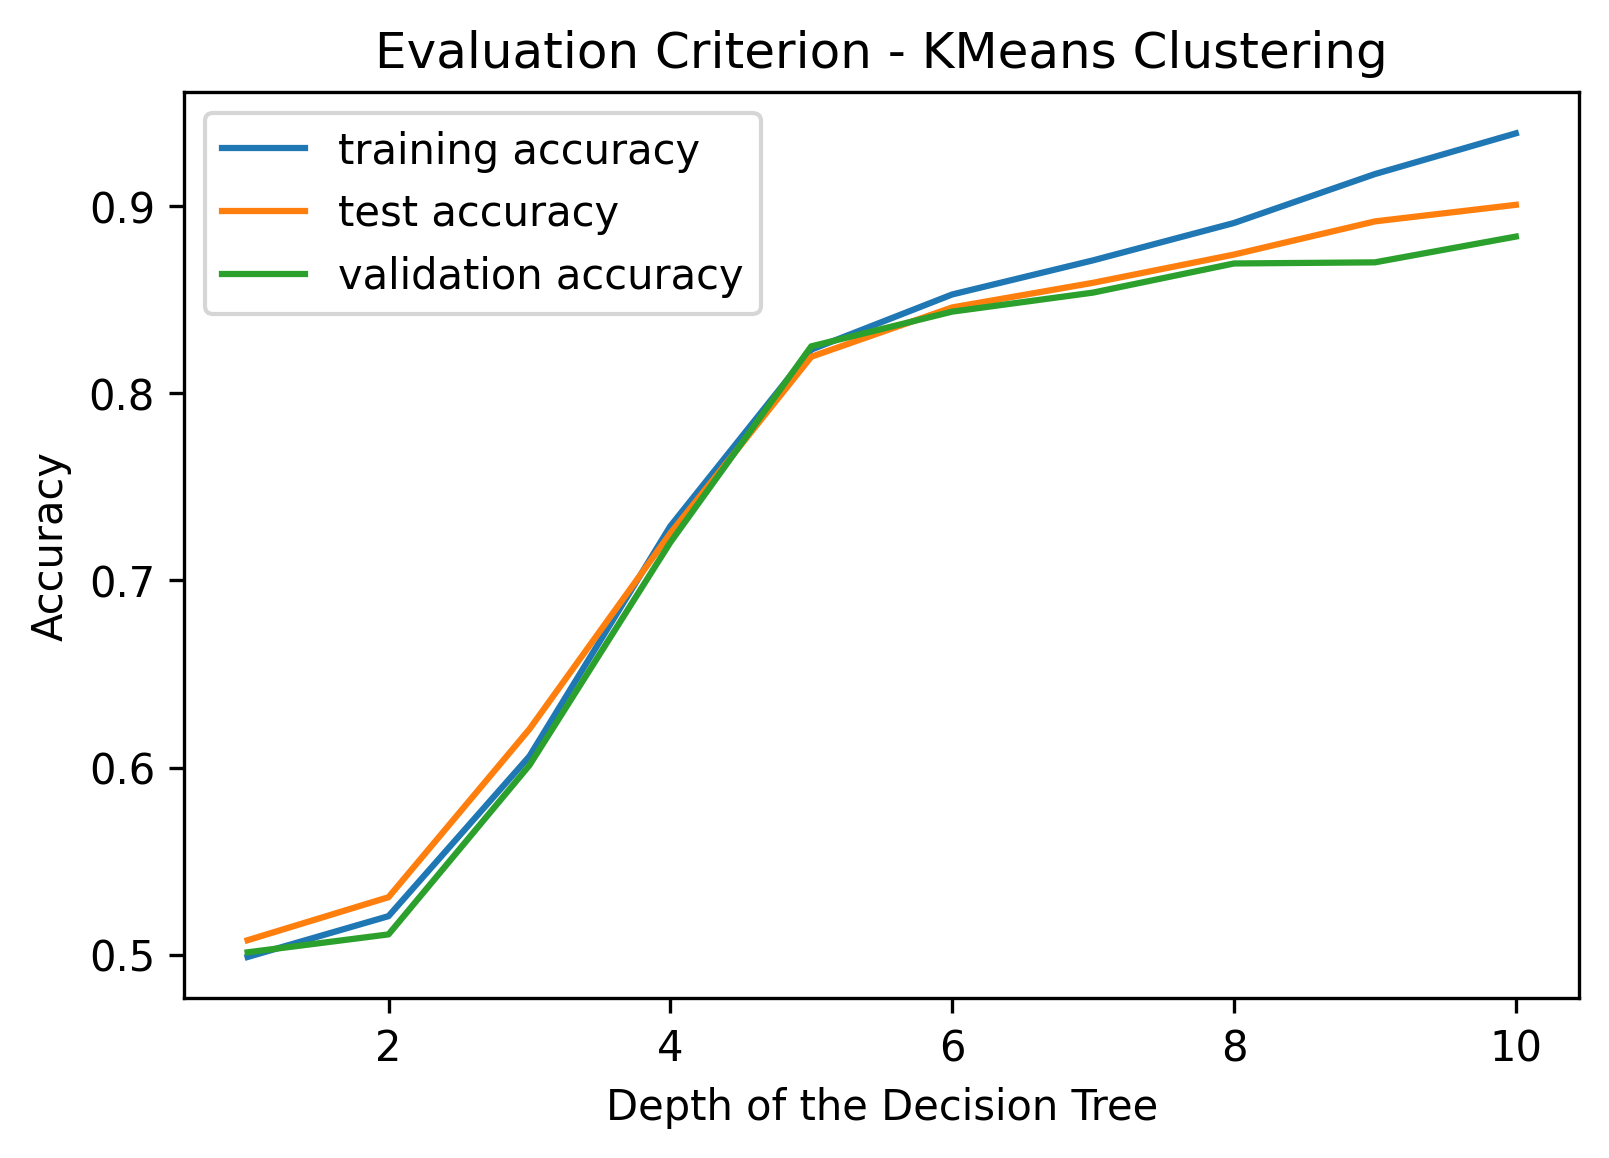

# Analysis for the Number of Nodes in the Tree

In [ ]:
plt.plot(nodes, train_accuracies, label="training accuracy")
plt.plot(nodes, test_accuracies, label="test accuracy")
plt.plot(nodes, val_accuracies, label="validation accuracy")
plt.legend()
plt.xlabel('Number of Nodes in the Decision Tree')
plt.ylabel('Accuracy')
plt.title("Evaluation Criterion - KMeans Clustering")
plt.savefig(f'node_analysis.png', dpi=300, bbox_inches='tight')
plt.clf()

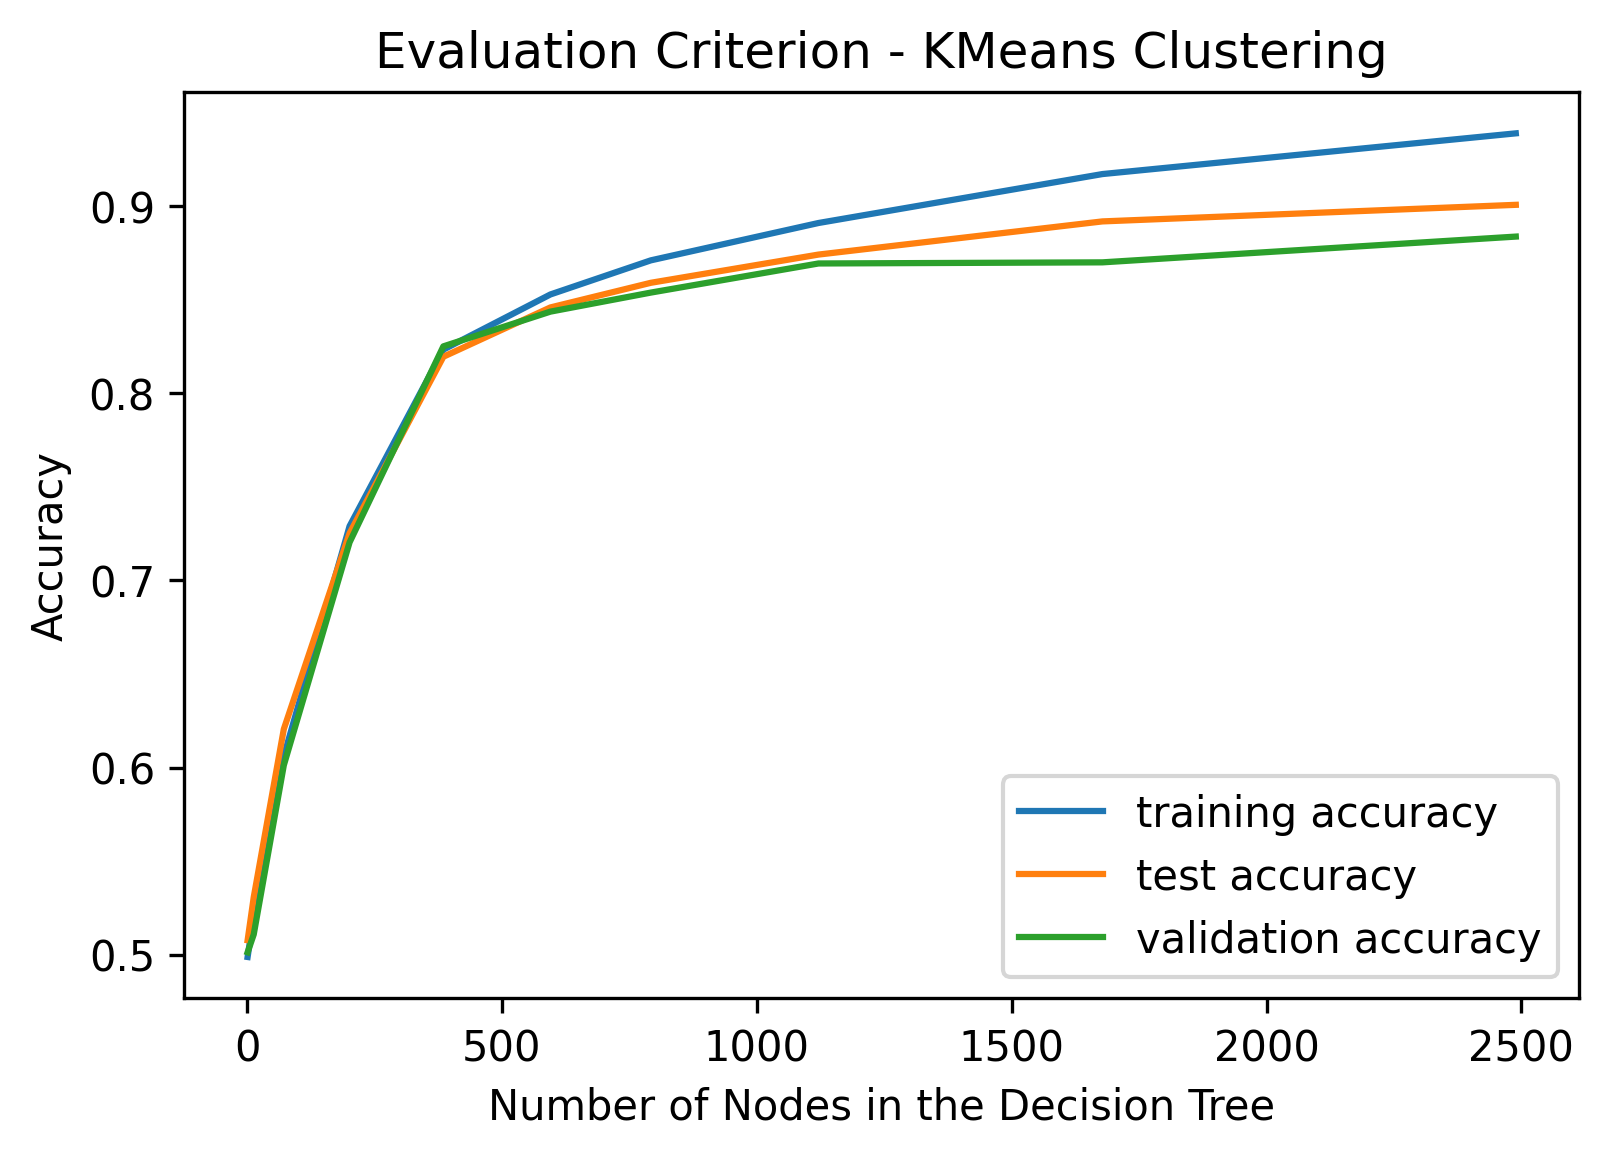

# Analysis of the status of tree during pruning

In [ ]:
final_model = pickle.load(open(filepath+"final_model.dat", "rb"))
final_X_train = np.load(open(filepath+"final_X_train.npy", "rb"), allow_pickle=True)
final_y_train = np.load(open(filepath+"final_y_train.npy", "rb"), allow_pickle=True)
final_X_test = np.load(open(filepath+"final_X_test.npy", "rb"), allow_pickle=True)
final_y_test = np.load(open(filepath+"final_y_test.npy", "rb"), allow_pickle=True)
final_X_valid = np.load(open(filepath+"final_X_valid.npy", "rb"), allow_pickle=True)
final_y_valid = np.load(open(filepath+"final_y_valid.npy", "rb"), allow_pickle=True)

model_temp = copy.deepcopy(final_model)
a, b, c, d = model_temp.prune_node_vary((final_X_train, final_y_train), (final_X_test, final_y_test), (final_X_valid, final_y_valid))
plt.plot(d, a, label="training accuracy")
plt.plot(d, b, label="test accuracy")
plt.plot(d, c, label="validation accuracy")
plt.legend()
plt.xlabel('Number of Nodes in the Decision Tree After Pruning')
plt.ylabel('Accuracy')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.title("Evaluation Criterion - KMeans Clustering")
plt.savefig(f'accuracy_analysis.png', dpi=300, bbox_inches='tight')
plt.clf()

************************
Pruning Step : 0
Number of nodes in the tree: 3443
************************

************************
Pruning Step : 1
Number of nodes in the tree: 3325
************************

************************
Pruning Step : 2
Number of nodes in the tree: 3319
************************

************************
Pruning Step : 3
Number of nodes in the tree: 3289
************************

************************
Pruning Step : 4
Number of nodes in the tree: 3273
************************

************************
Pruning Step : 5
Number of nodes in the tree: 3268
************************

************************
Pruning Step : 6
Number of nodes in the tree: 3228
************************

************************
Pruning Step : 7
Number of nodes in the tree: 3190
************************

************************
Pruning Step : 8
Number of nodes in the tree: 3168
************************

************************
Pruning Step : 9
Number of nodes in the tree: 3156
************************

************************
Pruning Step : 10
Number of nodes in the tree: 3134
************************

************************
Pruning Step : 11
Number of nodes in the tree: 3118
************************

************************
Pruning Step : 12
Number of nodes in the tree: 3106
************************

************************
Pruning Step : 13
Number of nodes in the tree: 3104
************************

************************
Pruning Step : 14
Number of nodes in the tree: 3088
************************

************************
Pruning Step : 15
Number of nodes in the tree: 3056
************************

************************
Pruning Step : 16
Number of nodes in the tree: 3054
************************

In [ ]:
# If pruning takes too long, stop the execution of the cell and make use of the saved numpy variables to complete the analysis
a = np.load(open(filepath+"train_accuracies.npy", "rb"), allow_pickle=True)
b = np.load(open(filepath+"test_accuracies.npy", "rb"), allow_pickle=True)
c = np.load(open(filepath+"val_accuracies.npy", "rb"), allow_pickle=True)
d = np.load(open(filepath+"prunes.npy", "rb"), allow_pickle=True)
plt.plot(d, a, label="training accuracy")
plt.plot(d, b, label="test accuracy")
plt.plot(d, c, label="validation accuracy")
plt.legend()
plt.xlabel('Number of Nodes in the Decision Tree After Pruning')
plt.ylabel('Accuracy')
ax = plt.gca()
ax.set_ylim([0, 1])
plt.title("Evaluation Criterion - KMeans Clustering")
plt.savefig(f'accuracy_analysis.png', dpi=300, bbox_inches='tight')
plt.clf()

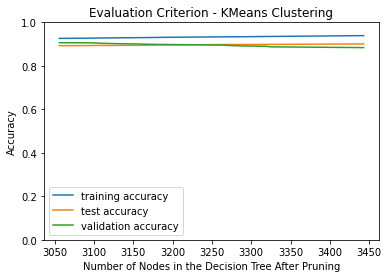

# Post-Pruning Analysis

In [ ]:
pruned_model = pickle.load(open(filepath+"pruning_step_15_decision_tree.dat", "rb"))
final_X_train = np.load(open(filepath+"final_X_train.npy", "rb"), allow_pickle=True)
final_y_train = np.load(open(filepath+"final_y_train.npy", "rb"), allow_pickle=True)
final_X_test = np.load(open(filepath+"final_X_test.npy", "rb"), allow_pickle=True)
final_y_test = np.load(open(filepath+"final_y_test.npy", "rb"), allow_pickle=True)
final_X_valid = np.load(open(filepath+"final_X_valid.npy", "rb"), allow_pickle=True)
final_y_valid = np.load(open(filepath+"final_y_valid.npy", "rb"), allow_pickle=True)

postPruningAnalysisFile = open('postPruningAnalysisFile.txt', 'w')
print("Number of nodes in the pruned tree: ", len(pruned_model.node_dict), file=postPruningAnalysisFile)

y_predict = pruned_model.predict(final_X_test)
ac = accuracy_score(final_y_test, y_predict)
print(f"Test Accuracy after Pruning = {ac * 100}%", file=postPruningAnalysisFile)

classes = np.unique(final_y_test)
matrix = confusion_matrix(final_y_test, y_predict, labels=classes)
print('Confusion matrix : \n', matrix, file=postPruningAnalysisFile)

matrix = classification_report(final_y_test, y_predict, labels=classes)
print('Classification report : \n', matrix, file=postPruningAnalysisFile)
postPruningAnalysisFile.close()

    Number of nodes in the pruned tree:  3054

    Test Accuracy after Pruning = 89.26689027311932%

    Confusion matrix : 
    
     [[1564    0    1    0    7  140   26   15    0    1    0    0]
     [   0    2    0    0    0    0    0    0    0    0    0    0]
     [   1    0   34    0    0    0    0    0    0    0    0    0]
     [   0    0    0  131   14    0    0    0    0    0    0    0]
     [   9    0    0    8  418    7    0    1    0    0    8    0]
     [ 100    0    0    0   10  639    4    4    0    0    0    0]
     [  12    0    0    0    9   18  138    6    0    0    0    0]
     [  17    0    1    0    3    8    0  184    0    0    0    0]
     [   0    0    0    0    0    0    0    0  323    0    0    0]
     [   0    0    0    0    0    0    0    0    0   15    0    0]
     [   6    0    0    0    4    0    0    0    0    0  174    6]
     [   0    0    0    0    0    0    0    0    0    0    2  104]]
     
    Classification report : 
               precision    recall  f1-score   support

           A       0.92      0.89      0.90      1754
           B       1.00      1.00      1.00         2
           C       0.94      0.97      0.96        35
           D       0.94      0.90      0.92       145
           E       0.90      0.93      0.91       451
           F       0.79      0.84      0.81       757
           G       0.82      0.75      0.79       183
           H       0.88      0.86      0.87       213
           I       1.00      1.00      1.00       323
           W       0.94      1.00      0.97        15
           X       0.95      0.92      0.93       190
           Y       0.95      0.98      0.96       106

        accuracy                           0.89      4174
       macro avg       0.92      0.92      0.92      4174
    weighted avg       0.89      0.89      0.89      4174



# Analysis using n-Decision Attribute Combination

In [ ]:
def n_decision_attribute_analysis(X_train, y_train, X_test, y_test, column_names, n):
    model = DecisionTreeClassifier(reuse_attribute=True, max_depth=100, number_of_decision_attributes=n, distance_metric=None, clustering_algorithm='kmeans++', clustering_max_iter=300)
    model.fit(X_train, y_train, column_names)
    pickle.dump(model, open(f"{n}_decision_attribute_decision_tree.dat", "wb"))
    model.print_decision_tree(f"{n}_decision_attribute_") 
    y_predict = model.predict(X_test)
    ac = accuracy_score(y_test, y_predict)
    return ac

In [ ]:
final_X_train = np.load(open(filepath+"final_X_train.npy", "rb"), allow_pickle=True)
final_y_train = np.load(open(filepath+"final_y_train.npy", "rb"), allow_pickle=True)
final_X_test = np.load(open(filepath+"final_X_test.npy", "rb"), allow_pickle=True)
final_y_test = np.load(open(filepath+"final_y_test.npy", "rb"), allow_pickle=True)
N = len(column_names)-1
print(N)

### n = 2

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 2)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 2 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

***********************
Number of decision attributes = 2 
Accuracy = 88.76377575467178%
***********************

### n = 3

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 3)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 3 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

***********************
Number of decision attributes = 3 
Accuracy = 99.40105414470531%
***********************

### n = 4

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 4)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 4 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

### n = 5

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 5)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 5 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

### n = 6

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 6)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 6 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

### n = 7

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 7)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 7 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

***********************
Number of decision attributes = 7 
Accuracy = 68.44753234307619%
***********************

### n = 8

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 8)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 8 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

***********************
Number of decision attributes = 8 
Accuracy = 67.58505031145184%
***********************


### n = 9

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 9)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 9 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

***********************
Number of decision attributes = 9 
Accuracy = 66.81839961667465%
***********************

### n = 10

In [ ]:
ac = n_decision_attribute_analysis(final_X_train, final_y_train, final_X_test, final_y_test, column_names, 10)
nDecisionAttributeAnalysisFile = open('nDecisionAttributeAnalysisFile.txt', 'a')
print("***********************", file=nDecisionAttributeAnalysisFile)
print(f"Number of decision attributes = 10 ", file=nDecisionAttributeAnalysisFile)
print(f"Accuracy = {ac * 100}%", file=nDecisionAttributeAnalysisFile)
print("***********************", file=nDecisionAttributeAnalysisFile)
nDecisionAttributeAnalysisFile.close()

***********************
Number of decision attributes = 10 
Accuracy = 69.76521322472449%
***********************


# Analysis PART - 2

### Let us perform a quick Exploratory Data Analysis on the Dataset and try to build an even better model using the same Decision Tree Classifier Model as above.

In [ ]:
filepath = '../input/avila-dataset-and-saved-variables/'

In [ ]:
df = pd.read_csv(filepath+'avila_combined.txt', delimiter=",", header=None)

column_names = ['index', 'intercolumnar distance', 'upper margin', 'lower margin', 'exploitation', 'row number', 'modular ratio',
              'interlinear spacing', 'weight', 'peak number', 'modular ratio/ interlinear spacing']

df.isnull().sum()

X = df.iloc[:, 0:-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

index = np.arange(X.shape[0])
X = np.c_[index, X]

In [ ]:
plt.hist(y)
plt.legend()
plt.xlabel('Class Label')
plt.ylabel('Number of instances')
plt.title("Exploratory Data Analysis")
plt.savefig(f'class_frequency.png', dpi=300, bbox_inches='tight')
plt.clf()

### It can be clearly seen that class 'A' dominates the dataset causing the decision tree to be extremely biased towards 'A'.

### **Possible Approach: Build a Decision Tree to classify 'A' and NOT-'A' and then further classify NOT-'A' using another Decision Tree as one of the rest of the classes.**

In [ ]:
X_sub, X_test, y_sub, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_sub, y_sub, test_size=0.1)

In [ ]:
y_train_modified = copy.deepcopy(y_train)
y_train_modified[y_train != 'A'] = 'S'

y_valid_modified = copy.deepcopy(y_valid)
y_valid_modified[y_valid != 'A'] = 'S'

In [ ]:
model1 = DecisionTreeClassifier(reuse_attribute=False, max_depth=100, number_of_decision_attributes=1, distance_metric=None, clustering_algorithm='kmeans++', clustering_max_iter=300)
model1.fit(X_train, y_train_modified, column_names)
pickle.dump(model1, open(f"model1_decision_tree.dat", "wb"))
model1.print_decision_tree(f"model1_")

num_nodes = len(model1.node_dict)
model1.prune((X_valid, y_valid_modified), minimum_increase=0.000001, maximum_rounds=num_nodes, sample_size=num_nodes, stopping_rounds=0)
pickle.dump(model1, open(f"pruned_model1_decision_tree.dat", "wb"))
model1.print_decision_tree(f"pruned_model1_")

************************
Pruning Step:  0
Number of nodes in the Tree:  411
Accuracy:  0.6880239520958084
************************
************************
Pruning Step:  1
Number of nodes in the Tree:  397
Accuracy:  0.6904191616766467
************************
************************
Pruning Step:  2
Number of nodes in the Tree:  373
Accuracy:  0.692814371257485
************************
************************
Pruning Step:  3
Number of nodes in the Tree:  371
Accuracy:  0.6946107784431138
************************
************************
Pruning Step:  4
Number of nodes in the Tree:  369
Accuracy:  0.6958083832335329
************************
************************
Pruning Step:  5
Number of nodes in the Tree:  367
Accuracy:  0.6970059880239521
************************
************************
Pruning Step:  6
Number of nodes in the Tree:  361
Accuracy:  0.6976047904191617
************************
************************
Pruning Step:  7
Number of nodes in the Tree:  359
Accuracy:  0.6982035928143713
************************
************************
Pruning Step:  8
Number of nodes in the Tree:  327
Accuracy:  0.6988023952095809
************************
************************
Pruning Step:  9
Number of nodes in the Tree:  321
Accuracy:  0.6994011976047905
************************

In [ ]:
model2 = DecisionTreeClassifier(reuse_attribute=False, max_depth=100, number_of_decision_attributes=1, distance_metric=None, clustering_algorithm='kmeans++', clustering_max_iter=300)
model2.fit(X_train[y_train != 'A'], y_train[y_train != 'A'], column_names)
pickle.dump(model2, open(f"model2_decision_tree.dat", "wb"))
model2.print_decision_tree(f"model2_")

num_nodes = len(model2.node_dict)
model2.prune((X_valid[y_valid != 'A'], y_valid[y_valid != 'A']), minimum_increase=0.000001, maximum_rounds=num_nodes, sample_size=num_nodes, stopping_rounds=0)
pickle.dump(model2, open(f"pruned_model2_decision_tree.dat", "wb"))
model2.print_decision_tree(f"pruned_model2_")

************************
Pruning Step:  0
Number of nodes in the Tree:  1537
Accuracy:  0.9242579324462641
************************
************************
Pruning Step:  1
Number of nodes in the Tree:  1529
Accuracy:  0.9263050153531218
************************
************************
Pruning Step:  2
Number of nodes in the Tree:  1523
Accuracy:  0.9283520982599796
************************
************************
Pruning Step:  3
Number of nodes in the Tree:  1509
Accuracy:  0.9293756397134084
************************
************************
Pruning Step:  4
Number of nodes in the Tree:  1501
Accuracy:  0.9303991811668373
************************
************************
Pruning Step:  5
Number of nodes in the Tree:  1498
Accuracy:  0.9314227226202662
************************
************************
Pruning Step:  6
Number of nodes in the Tree:  1474
Accuracy:  0.932446264073695
************************
************************
Pruning Step:  7
Number of nodes in the Tree:  1472
Accuracy:  0.9334698055271239
************************
************************
Pruning Step:  8
Number of nodes in the Tree:  1465
Accuracy:  0.9344933469805528
************************
************************
Pruning Step:  9
Number of nodes in the Tree:  1463
Accuracy:  0.9355168884339816
************************
************************
Pruning Step:  10
Number of nodes in the Tree:  1461
Accuracy:  0.9365404298874105
************************
************************
Pruning Step:  11
Number of nodes in the Tree:  1459
Accuracy:  0.9375639713408394
************************
************************
Pruning Step:  12
Number of nodes in the Tree:  1437
Accuracy:  0.9385875127942682
************************
************************
Pruning Step:  13
Number of nodes in the Tree:  1435
Accuracy:  0.9396110542476971
************************
************************
Pruning Step:  14
Number of nodes in the Tree:  1433
Accuracy:  0.9406345957011258
************************
************************
Pruning Step:  15
Number of nodes in the Tree:  1431
Accuracy:  0.9416581371545547
************************
************************
Pruning Step:  16
Number of nodes in the Tree:  1418
Accuracy:  0.9426816786079836
************************
************************
Pruning Step:  17
Number of nodes in the Tree:  1416
Accuracy:  0.9437052200614124
************************

In [ ]:
def predict_using_model1_and_model2(X):
    model1_y_predict = np.asarray(model1.predict(X))
    model1_y_predict[model1_y_predict == 'S'] = np.asarray(model2.predict(X[model1_y_predict == 'S']))
    return model1_y_predict

In [ ]:
y_predict = predict_using_model1_and_model2(X_test)
ac = accuracy_score(y_test, y_predict)
print(f"Accuracy using model1 and model2= {ac * 100}%")

Accuracy using model1 and model2= 63.34451365596549%

### **We see that this approach does not work better rather performs much worse. A plausible reason can be that in our approach we depend on similarity amongst data points to cluster them and then perform the node split. Thus in model1, at any node which is to be split it is likely that the split is not optimal because 'S' is actually a mixture of 'B', 'C' etc.**

### Example: An example of 'A' can be close to 'B', but not that close. In this second approach, the model1 may see that the example is close to 'S' (because it is close to 'B')  and thus sends it to model2, but model2 has no way to classify it as 'A' thus leading to a missclassification.

### This clearly shows that model1 bottlenecks model2.

### ***But the age old question remains, can we do better?***